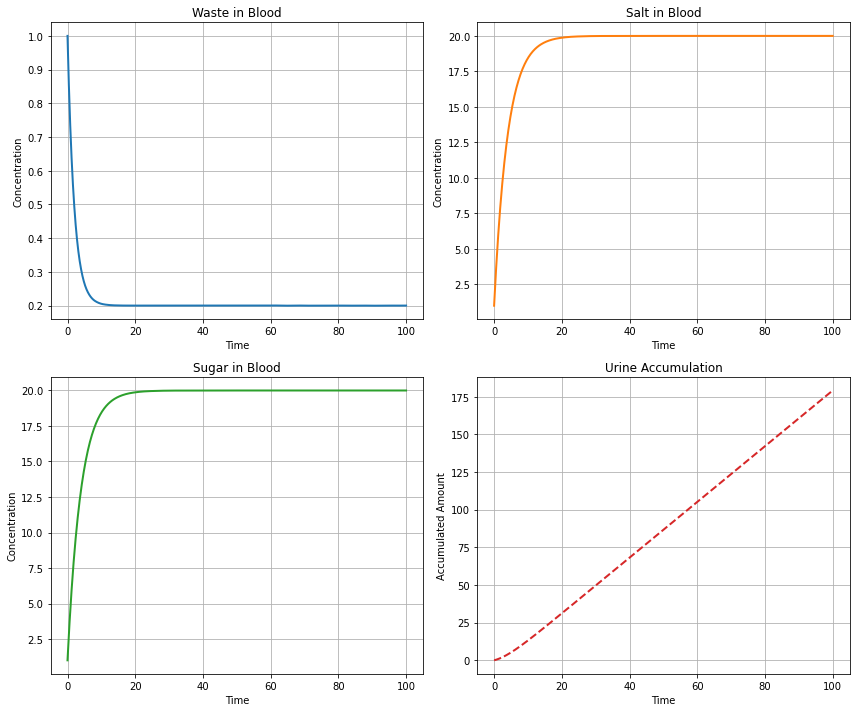

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass

# Define the kidney parameters using a data class.
@dataclass
class KidneyParameters:
    V_blood: float           # Volume of the blood compartment.
    V_kidney: float          # Volume of the kidney compartment.
    waste_in: float          # Constant waste input from the renal artery.
    waste_kidney_urine: float  # Clearance rate: how fast waste is filtered into urine.
    salt_in: float           # Constant salt input from the renal artery.
    salt_kidney_filter: float  # Filtration rate for salt.
    salt_reabsorption: float   # Fraction of filtered salt that is reabsorbed.
    sugar_in: float          # Constant sugar input from the renal artery.
    sugar_kidney_filter: float  # Filtration rate for sugar.
    sugar_reabsorption: float   # Fraction of sugar reabsorbed.

# Overall kidney model: combines waste, salt, and sugar handling.
def kidney(t, y, p: KidneyParameters):
    """
    Computes the overall derivative of the kidney model.
    
    State vector y:
      y[0] : Waste in blood.
      y[1] : Salt in blood.
      y[2] : Sugar in blood.
      y[3] : Urine accumulation.
    """
    dwaste = waste_filter(t, y, p)
    dsalt   = salt_handling(t, y, p)
    dsugar  = sugar_handling(t, y, p)
    dydt = dwaste + dsalt + dsugar
    return dydt

# Waste handling: waste enters from the renal artery and is cleared via filtration.
def waste_filter(t, y, p: KidneyParameters):
    dydt = np.zeros(4)
    # Waste in blood: waste enters at a constant rate and is cleared proportionally.
    # d(waste in blood)/dt = waste_in - waste_kidney_urine * (waste in blood)
    dydt[0] = p.waste_in - p.waste_kidney_urine * y[0]
    # Waste that is cleared is added to the urine.
    dydt[3] = p.waste_kidney_urine * y[0]
    return dydt

# Salt handling: models filtration and reabsorption of salt.
def salt_handling(t, y, p: KidneyParameters):
    dydt = np.zeros(4)
    filteredSalt = p.salt_kidney_filter * y[1] * p.V_blood
    reabsorbedSalt = p.salt_reabsorption * filteredSalt
    dydt[1] = (p.salt_in * p.V_blood - filteredSalt) / p.V_kidney
    dydt[3] = (filteredSalt - reabsorbedSalt) / p.V_kidney
    return dydt

# Sugar handling: similar to salt handling.
def sugar_handling(t, y, p: KidneyParameters):
    dydt = np.zeros(4)
    filteredSugar = p.sugar_kidney_filter * y[2] * p.V_blood
    reabsorbedSugar = p.sugar_reabsorption * filteredSugar
    dydt[2] = (p.sugar_in * p.V_blood - filteredSugar) / p.V_kidney
    dydt[3] = (filteredSugar - reabsorbedSugar) / p.V_kidney
    return dydt

# Set example parameter values.
# Here, waste_in is set to 0.1 and waste_kidney_urine to 0.5, so the steady state for waste in blood is 0.2.
params = KidneyParameters(
    V_blood=5.0,
    V_kidney=1.0,
    waste_in=0.1,              # Waste enters continuously at 0.1 units.
    waste_kidney_urine=0.5,      # Clearance rate: high enough to ensure waste decreases from initial value.
    salt_in=1.0,               # Constant salt input.
    salt_kidney_filter=0.05,    # Salt filtration rate.
    salt_reabsorption=0.7,      # Fraction of salt reabsorbed.
    sugar_in=1.0,              # Constant sugar input.
    sugar_kidney_filter=0.05,   # Sugar filtration rate.
    sugar_reabsorption=0.95     # Fraction of sugar reabsorbed.
)

# Initial conditions for the state vector:
# [waste in blood, salt in blood, sugar in blood, urine accumulation]
y0 = np.array([1.0, 1.0, 1.0, 0.0])

# Define the simulation time span and evaluation points.
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Wrapper for the ODE solver.
def kidney_ode(t, y):
    return kidney(t, y, params)

# Solve the ODE system using SciPy's solve_ivp.
sol = solve_ivp(kidney_ode, t_span, y0, t_eval=t_eval)

# Create separate subplots for each variable.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Waste in Blood.
axs[0, 0].plot(sol.t, sol.y[0], linewidth=2, color='tab:blue')
axs[0, 0].set_title('Waste in Blood')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Concentration')
axs[0, 0].grid(True)

# Salt in Blood.
axs[0, 1].plot(sol.t, sol.y[1], linewidth=2, color='tab:orange')
axs[0, 1].set_title('Salt in Blood')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Concentration')
axs[0, 1].grid(True)

# Sugar in Blood.
axs[1, 0].plot(sol.t, sol.y[2], linewidth=2, color='tab:green')
axs[1, 0].set_title('Sugar in Blood')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Concentration')
axs[1, 0].grid(True)

# Urine Accumulation.
axs[1, 1].plot(sol.t, sol.y[3], linewidth=2, linestyle='--', color='tab:red')
axs[1, 1].set_title('Urine Accumulation')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Accumulated Amount')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
